### You'll need Matplotlib, Shapely (>= 1.6b2), and Descartes

### You'll also need Rust. Get it from [rustup.rs](https://rustup.rs)

#### First, build a binary with some extra instrumentation – this writes the node positions to a text file

In [35]:
%%bash
cargo build --release

    Finished release [optimized] target(s) in 0.0 secs


In [42]:
from matplotlib import pyplot as plt
from matplotlib.collections import PatchCollection
from shapely.geometry import LineString, Polygon, Point, box
from shapely.geometry.multipolygon import asMultiPolygon
from descartes import PolygonPatch
from ffi import label_position
from ast import literal_eval

%matplotlib inline

#### This is our initial polygon. You can substitute your own if you like – just set `initial_polygon` to a valid Shapely `Polygon`

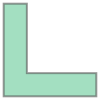

In [58]:
initial_polygon = Polygon([
    (0.0, 0.0),
    (4.0, 0.0),
    (4.0, 1.0),
    (1.0, 1.0),
    (1.0, 4.0),
    (0.0, 4.0),
    (0.0, 0.0)
])

initial_polygon

#### Now find its pole of inacessibility. This also dumps the node coordinates to `nodes.txt`

In [59]:
label = Point(label_position(initial_polygon, tolerance=0.1))

Convert the nodes into Boxes

In [60]:
# eval 😱 – but it's safe
with open('nodes.txt', 'r') as f:
    quad_polygons = [box(*tup) for tup in map(literal_eval, f)]

# get quadtree bounds
bounds = asMultiPolygon(quad_polygons).bounds

In [44]:
save_args = {
    "format": "png",
    "bbox_inches": 'tight',
    "pad_inches": 0,
    "alpha": True,
    "transparent": True,
    "dpi": 300
}

#### Draw one frame per Box

In [ ]:
fig = plt.figure(1, figsize=(5., 5.), dpi=300)
ax = fig.add_subplot(121)
ax.set_aspect('equal')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.axis('off')
ax.set_xlim(bounds[0] - .15, bounds[2] + .15)
ax.set_ylim(bounds[1] - .15, bounds[3] + .15)

# add initial polygon
ax.add_patch(PolygonPatch(initial_polygon, fc='None', ec='#000000', lw=0.5, alpha=1.0, zorder=2))
# add centroid as dot patch
ax.add_patch(PolygonPatch(initial_polygon.centroid.buffer(.025), lw=0.25, fc='#ffa500', ec='#000000', zorder=4))
plt.savefig("data/polylabel_000.png", **save_args)

# build patches as needed
ppatches = (PolygonPatch(poly, fc='None', ec='#ff0000', alpha=1.0, zorder=3, lw=0.25) for poly in quad_polygons)

# consume consume
for i in xrange(1, len(quad_polygons) + 1):
    ax.add_patch(ppatches.next())
    plt.savefig("data/polylabel_{:03d}.png".format(i), **save_args)

# add pole of inaccessibility as patch
ax.add_patch(PolygonPatch(label.buffer(.025), lw=0.25, fc='#00b3b3', ec='#000000', zorder=4))

# save final plot
plt.savefig("data/polylabel_{:03d}.png".format(i + 1), **save_args)
plt.show()

#### Make a GIF, and a pause at the end so we can see the calculated point

In [ ]:
%%bash
convert -background white -alpha remove -layers OptimizePlus -set delay 20 -colors 512 -loop 0 -scale 100% data/*.png output.gif
convert output.gif \( +clone -set delay 300 \) +swap +delete  output.gif